In [1]:
import time
import numpy as np
from continuum.continuum import continuum
from continuum.data_utils import setup_test_loader
from utils.name_match import agents
from utils.setup_elements import setup_opt, setup_architecture
from utils.utils import maybe_cuda
from experiment.metrics import compute_performance, single_run_avg_end_fgt
from experiment.tune_hyperparam import tune_hyper
from types import SimpleNamespace
from utils.io import load_yaml, save_dataframe_csv, check_ram_usage
import pandas as pd
import os
import pickle
import torch

In [2]:
data = 'cifar10'
cl_type = 'nc'
params = ''

In [3]:
class Parameters:
    num_runs = 1
    seed = 1
    val_size = 1
    num_val  = 3
    num_runs_val = 3
    error_analysis = 3
    verbose = 0
    agent = "ER"
    update = 'random'
    retrieve = "random"
    weight_decay = 0
    num_tasks = 4
    fix_order = False
    plot_sample = False
    optimizer = 'SGD'
    learning_rate = 0.1
    epoch = 10
    batch = 10
    trick = {'labels_trick':False,
             'kd_trick':False,
             'kd_trick_star':False,
             "review_trick":False,
             "separated_softmax":False,
             "ncm_trick":False}
    data = "breathing"
    test_batch = 128
    retrieve = 'random'
    cl_type = 'nc'
    ns_factor = (0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6)
    ns_type = "noise"
    ns_task = (1, 1, 2, 2, 2, 2)
    online = True
    mem_size = 5000
    eps_mem_batch = 10
    lambda_ = 100
    alpha = 0.9
    fisher_update_after = 50
    subsample = 50 
    gss_mem_strength = 10 # Number of batches randomly sampled from memory to estimate score
    gss_batch_size = 10 #Random sampling batch size to estimate score
    k = 5 #Number of nearest neighbors (K) to perform ASER
    aser_type = "asvm"
    n_smp_cls = 2.0
    stm_capacity = 1000
    classifier_chill = 0.01 
    log_alpha = 300.0
    minlr = 0.0005 #Minimal learning rate
    clip = 10 #value for gradient clipping
    mem_epoch = 10 #Epochs to train for memory
    labels_trick = False
    separated_softmax = False
    kd_trick = False#Knowledge distillation with cross entropy trick
    kd_trick_star = False #Improved knowledge distillation trick
    review_trick = False
    ncm_trick = False #Use nearest class mean classifier
    mem_iters = 1 #
    min_delta = 0# A minimum increase in the score to qualify as an improvement
    patience = 0 # Number of events to wait if no improvement and then stop the training.
    cumulative_delta = False  # If True, `min_delta` defines an increase since the last `patience` reset,otherwise, it defines an increase after the last event.
    temp = 0.07 #temperature for loss function
    buffer_tracker = False #Keep track of buffer with a dictionary
    warmup = 4 #warmup of buffer before retrieve
    head = 'mlp'#projection head
    cuda = torch.cuda.is_available()

In [4]:
import argparse
import random
import numpy as np
import torch
from experiment.run import multiple_run
from utils.utils import boolean_string

In [5]:
#python general_main.py --data cifar100 --cl_type nc --agent ER --retrieve random --update random --mem_size 5000

In [6]:
params = Parameters

In [7]:
params.num_tasks = 2
params.fix_order = False

In [8]:
data = "breathing"


In [9]:
import numpy as np
from torchvision import datasets
from continuum.data_utils import create_task_composition, load_task_with_labels, shuffle_data
from continuum.dataset_scripts.dataset_base import DatasetBase
from continuum.non_stationary import construct_ns_multiple_wrapper, test_ns

In [10]:
from utils.name_match import data_objects

In [11]:
from continuum.dataset_scripts.breathing import BreathDataset

from continuum.dataset_scripts.breathdata_v2 import BreathDataset_v2

In [12]:
BreathDataset_v2(scenario='nc', params=params, sequence_length=20, overlap=0.1).setup()

Generate Slice Window data successfully
Generate Slice Window data successfully
Task: 0, Labels:[3, 0]
Task: 1, Labels:[1, 2]


In [13]:
data_objects['breathing'] = BreathDataset
data_objects['breathing_v2'] = BreathDataset_v2


In [14]:
data_objects

{'cifar100': continuum.dataset_scripts.cifar100.CIFAR100,
 'cifar10': continuum.dataset_scripts.cifar10.CIFAR10,
 'core50': continuum.dataset_scripts.core50.CORE50,
 'mini_imagenet': continuum.dataset_scripts.mini_imagenet.Mini_ImageNet,
 'openloris': continuum.dataset_scripts.openloris.OpenLORIS,
 'breathing': continuum.dataset_scripts.breathing.BreathDataset,
 'breathing_v2': continuum.dataset_scripts.breathdata_v2.BreathDataset_v2}

In [15]:
cl_type = 'nc'

In [16]:
start = time.time()
print('Setting up data stream')
data_continuum = continuum("breathing_v2", cl_type, params)
data_end = time.time()
print('data setup time: {}'.format(data_end - start))

Setting up data stream
Generate Slice Window data successfully
Generate Slice Window data successfully
data setup time: 0.03499913215637207


In [17]:
data_continuum.data_object.train_data.shape

(3999, 20, 3)

In [18]:
from continuum.dataset_scripts.cifar10 import CIFAR10

In [19]:
from continuum.dataset_scripts.breathing import BreathDataset

from continuum.dataset_scripts.breathdata_v2 import BreathDataset_v2

In [20]:
BreathDataset_v2(scenario='nc', params=params, sequence_length=20, overlap=0.1)

Generate Slice Window data successfully
Generate Slice Window data successfully


In [21]:
import numpy as np
from torchvision import datasets
from continuum.data_utils import create_task_composition, load_task_with_labels, shuffle_data
from continuum.dataset_scripts.dataset_base import DatasetBase
from continuum.non_stationary import construct_ns_multiple_wrapper, test_ns



In [22]:
from utils.name_match import data_objects

In [23]:
data_objects['breathing_v2'] = BreathDataset_v2

In [24]:
data_objects

{'cifar100': continuum.dataset_scripts.cifar100.CIFAR100,
 'cifar10': continuum.dataset_scripts.cifar10.CIFAR10,
 'core50': continuum.dataset_scripts.core50.CORE50,
 'mini_imagenet': continuum.dataset_scripts.mini_imagenet.Mini_ImageNet,
 'openloris': continuum.dataset_scripts.openloris.OpenLORIS,
 'breathing': continuum.dataset_scripts.breathing.BreathDataset,
 'breathing_v2': continuum.dataset_scripts.breathdata_v2.BreathDataset_v2}

In [25]:
params.num_tasks = 2
params.fix_order = False

In [26]:
class BreathDataset(DatasetBase):
    def __init__(self, scenario, params, sequence_length= 20, overlap = 0.1):
        self.sequence_length = sequence_length
        self.step  = int(sequence_length - overlap * sequence_length)
        dataset = 'cifar10'
        if scenario == 'ni':
            num_tasks = len(params.ns_factor)
        else:
            num_tasks = params.num_tasks
        super(BreathDataset, self).__init__(dataset, scenario, num_tasks, params.num_runs, params)
    def download_load(self):
        trainset = np.load(file="./datasets/dynamic/dynamic_train_set.npy")[:, 1:]
        testset = np.load(file="./datasets/dynamic/dynamic_test_set.npy")[:, 1:]
        valset = np.load(file="./datasets/dynamic/dynamic_val_set.npy")[:, 1:]
        self.train_data, self.train_label = self.slice_window(data= trainset[:, :3], labels=trainset[:, -1])
        self.test_data, self.test_label = self.slice_window(data= testset[:, :3], labels=testset[:, -1])
        self.val_data, self.val_label = self.slice_window(data= valset[:, :3], labels=valset[:, -1])
        print("Generate Slice Window data successfully")
    def setup(self):
        if self.scenario == 'ni':
            self.train_set, self.val_set, self.test_set = construct_ns_multiple_wrapper(self.train_data,
                                                                                        self.train_label,
                                                                                        self.test_data, self.test_label,
                                                                                        self.task_nums, 32,
                                                                                        self.params.val_size,
                                                                                        self.params.ns_type, self.params.ns_factor,
                                                                                        plot=self.params.plot_sample)
        elif self.scenario == 'nc':
            self.task_labels = create_task_composition(class_nums=4, num_tasks=self.task_nums, fixed_order=self.params.fix_order)
            self.test_set = []
            for labels in self.task_labels:
                x_test, y_test = load_task_with_labels(self.test_data, self.test_label, labels)
                self.test_set.append((x_test, y_test))
        else:
            raise Exception('wrong scenario')


    def new_task(self, cur_task, **kwargs):
        if self.scenario == 'ni':
            x_train, y_train = self.train_set[cur_task]
            labels = set(y_train)
        elif self.scenario == 'nc':
            labels = self.task_labels[cur_task]
            x_train, y_train = load_task_with_labels(self.train_data, self.train_label, labels)
        return x_train, y_train, labels

        
    def new_run(self, **kwargs):
        self.setup()
        return self.test_set

    def test_plot(self):
        test_ns(self.train_data[:10], self.train_label[:10], self.params.ns_type,
                                                         self.params.ns_factor)
        

    def slice_window(self, data, labels):
        X_local = []
        y_local = []
        for start in range(0, data.shape[0] - self.sequence_length, self.step):
            end = start + self.sequence_length
            X_local.append(data[start:end])
            y_local.append(labels[end-1])
        return np.array(X_local), np.array(y_local)
    
    


In [27]:
breathdata = BreathDataset(scenario='nc', params=params, sequence_length=20, overlap=0.1)
breathdata.setup()

Generate Slice Window data successfully
Task: 0, Labels:[0, 2]
Task: 1, Labels:[1, 3]


In [28]:
labels = breathdata.task_labels
dataset = breathdata.train_data
y_label = breathdata.train_label

In [29]:
dataset.shape

(3999, 20, 3)

In [30]:
from torch.utils import data

In [31]:
import torch
from torch.utils import data
from utils.buffer.buffer import Buffer
from agents.base import ContinualLearner
from continuum.data_utils import dataset_transform
from utils.setup_elements import transforms_match
from utils.utils import maybe_cuda, AverageMeter


In [32]:
from utils.setup_elements import transforms_match


In [33]:
transforms_match['breathing']

Compose(
    ToTensor()
)

In [34]:
class dataset_transform(data.Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.transform = transform  # save the transform

    def __len__(self):
        return len(self.y)#self.x.shape[0]  # return 1 as we have only one image

    def __getitem__(self, idx):
        # return the augmented image
        if self.transform:
            x = self.transform(self.x[idx])
        else:
            x = self.x[idx]

        return x.float(), self.y[idx]

In [35]:
traindataset = dataset_transform(dataset, y_label, transform=transforms_match[params.data])

In [36]:
datasets = data.DataLoader(traindataset, batch_size=10, shuffle=True)

In [37]:
x, y = next(iter(datasets))

In [38]:
from agents.base import ContinualLearner

In [39]:
import torch
from torch.utils import data
from utils.buffer.buffer import Buffer

In [40]:
from utils.setup_elements import transforms_match
from utils.utils import maybe_cuda, AverageMeter

In [41]:
params.mem_size = 200

In [42]:
class ExperienceReplay(ContinualLearner):
    def __init__(self, model, opt, params):
        super(ExperienceReplay, self).__init__(model, opt, params)
        self.buffer = Buffer(model, params)
        self.mem_size = params.mem_size
        self.eps_mem_batch = params.eps_mem_batch
        self.mem_iters = params.mem_iters
        self.loss_epochs = []
        self.acc_epochs = []
        self.losses_batch = AverageMeter()
        self.losses_mem = AverageMeter()
        self.acc_batch = AverageMeter()
        self.acc_mem = AverageMeter()

    def train_learner(self, x_train, y_train):
        self.before_train(x_train, y_train)
        # set up loader
        train_dataset = dataset_transform(x_train, y_train, transform=transforms_match[self.data])
        train_loader = data.DataLoader(train_dataset, batch_size=self.batch, shuffle=True, num_workers=0,
                                       drop_last=True)
        # set up model
        self.model = self.model.train()

        # # setup tracker
        # self.losses_batch = AverageMeter()
        # self.losses_mem = AverageMeter()
        # self.acc_batch = AverageMeter()
        # self.acc_mem = AverageMeter()

        for ep in range(self.epoch):
            for i, batch_data in enumerate(train_loader):
                # batch update
                batch_x, batch_y = batch_data
                print("batch data:", batch_x.size())
                batch_x = maybe_cuda(batch_x, self.cuda)
                batch_y = maybe_cuda(batch_y, self.cuda)
                print(batch_x.size())
                batch_x = batch_x.view(batch_x.size(0), batch_x.size(2), batch_x.size(3))
                print(batch_x.size())
                for j in range(self.mem_iters):
                    # batch_x = batch_x.view(batch_x.size(0), batch_x.size(2), batch_x.size(3))
                    logits = self.model.forward(batch_x)
                    loss = self.criterion(logits, batch_y)
                    if self.params.trick['kd_trick']:
                        loss = 1 / (self.task_seen + 1) * loss + (1 - 1 / (self.task_seen + 1)) * \
                                   self.kd_manager.get_kd_loss(logits, batch_x)
                    if self.params.trick['kd_trick_star']:
                        loss = 1/((self.task_seen + 1) ** 0.5) * loss + \
                               (1 - 1/((self.task_seen + 1) ** 0.5)) * self.kd_manager.get_kd_loss(logits, batch_x)
                    _, pred_label = torch.max(logits, 1)
                    correct_cnt = (pred_label == batch_y).sum().item() / batch_y.size(0)
                    # update tracker
                    self.acc_batch.update(correct_cnt, batch_y.size(0))
                    self.losses_batch.update(loss, batch_y.size(0))
                    # backward
                    self.opt.zero_grad()
                    loss.backward()

                    # mem update
                    mem_x, mem_y = self.buffer.retrieve(x=batch_x, y=batch_y)
                    if mem_x.size(0) > 0:
                        mem_x = maybe_cuda(mem_x, self.cuda)
                        mem_y = maybe_cuda(mem_y, self.cuda)
                        mem_logits = self.model.forward(mem_x)
                        loss_mem = self.criterion(mem_logits, mem_y)
                        if self.params.trick['kd_trick']:
                            loss_mem = 1 / (self.task_seen + 1) * loss_mem + (1 - 1 / (self.task_seen + 1)) * \
                                       self.kd_manager.get_kd_loss(mem_logits, mem_x)
                        if self.params.trick['kd_trick_star']:
                            loss_mem = 1 / ((self.task_seen + 1) ** 0.5) * loss_mem + \
                                   (1 - 1 / ((self.task_seen + 1) ** 0.5)) * self.kd_manager.get_kd_loss(mem_logits,
                                                                                                         mem_x)
                        # update tracker
                        self.losses_mem.update(loss_mem, mem_y.size(0))
                        _, pred_label = torch.max(mem_logits, 1)
                        correct_cnt = (pred_label == mem_y).sum().item() / mem_y.size(0)
                        self.acc_mem.update(correct_cnt, mem_y.size(0))

                        loss_mem.backward()

                    if self.params.update == 'ASER' or self.params.retrieve == 'ASER':
                        # opt update
                        self.opt.zero_grad()
                        combined_batch = torch.cat((mem_x, batch_x))
                        combined_labels = torch.cat((mem_y, batch_y))
                        combined_logits = self.model.forward(combined_batch)
                        loss_combined = self.criterion(combined_logits, combined_labels)
                        loss_combined.backward()
                        self.opt.step()
                    else:
                        self.opt.step()

                # update mem
                self.buffer.update(batch_x, batch_y)

                if i % 1 == 1 and self.verbose:
                    print(
                        '==>>> it: {}, avg. loss: {:.6f}, '
                        'running train acc: {:.3f}'
                            .format(i, self.losses_batch.avg(), self.acc_batch.avg())
                    )
                    print(
                        '==>>> it: {}, mem avg. loss: {:.6f}, '
                        'running mem acc: {:.3f}'
                            .format(i, self.losses_mem.avg(), self.acc_mem.avg())
                    )
            self.acc_epochs.append(self.acc_batch.avg())
            self.loss_epochs.append(self.losses_batch.avg())
        self.after_train()


In [43]:
x.shape

torch.Size([10, 1, 20, 3])

### COntinual Dataset


In [44]:
start = time.time()
print('Setting up data stream')
data_continuum = continuum("breathing_v2", cl_type, params)
data_end = time.time()
print('data setup time: {}'.format(data_end - start))

Setting up data stream
Generate Slice Window data successfully
Generate Slice Window data successfully
data setup time: 0.037895917892456055


### Load model

In [45]:
data_continuum.new_run()

Task: 0, Labels:[1, 3]
Task: 1, Labels:[2, 0]


In [46]:
from models.lstm import LSTMModel
import torchinfo

In [47]:
import torch

In [48]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [49]:
input_dim = 3
hidden_dim = 100
sequence_dim = 28
layer_dim = 1
output_dim = 10
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
print(model.eval)

<bound method Module.eval of LSTMModel(
  (lstm): LSTM(3, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=10, bias=True)
)>


In [50]:
X = torch.randn((1, 20, 3))
X.size()

torch.Size([1, 20, 3])

In [51]:
model(X)

tensor([[ 0.0926, -0.1011, -0.0603,  0.0613,  0.0034, -0.0652, -0.0623,  0.0023,
         -0.0512, -0.0120]], grad_fn=<AddmmBackward0>)

In [52]:
from torchinfo import summary

In [53]:
summary(model=model, input_size=(1, 20, 3))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 10]                   --
├─LSTM: 1-1                              [1, 20, 100]              42,000
├─Linear: 1-2                            [1, 10]                   1,010
Total params: 43,010
Trainable params: 43,010
Non-trainable params: 0
Total mult-adds (M): 0.84
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.17
Estimated Total Size (MB): 0.19

In [54]:
from utils.setup_elements import input_size_match, transforms_match

In [55]:
params.mem_size = 0

In [56]:
opt = setup_opt(params.optimizer, model, params.learning_rate, params.weight_decay)

In [57]:
agent_exp = ExperienceReplay(model=model, opt=opt, params=params)

buffer has 0 slots


In [58]:
agent_exp.acc_epochs

[]

In [59]:
accuracy_list = []
for run in range(params.num_runs):
        tmp_acc = []
        run_start = time.time()
        data_continuum.new_run()
        model = model
        model = maybe_cuda(model, params.cuda)
        opt = setup_opt(params.optimizer, model, params.learning_rate, params.weight_decay)
        agent = agent_exp
        test_loaders = setup_test_loader(data_continuum.test_data(), params)
        if params.online:
            for i, (x_train, y_train, labels) in enumerate(data_continuum):
                print("-----------run {} training batch {}-------------".format(run, i))
                print('size: {}, {}'.format(x_train.shape, y_train.shape))
                agent.train_learner(x_train, y_train)
                acc_array = agent.evaluate(test_loaders)
                tmp_acc.append(acc_array)
            run_end = time.time()
            print(
                "-----------run {}-----------avg_end_acc {}-----------train time {}".format(run, np.mean(tmp_acc[-1]),
                                                                                run_end - run_start))
            accuracy_list.append(np.array(tmp_acc))
        else:
            x_train_offline = []
            y_train_offline = []
            for i, (x_train, y_train, labels) in enumerate(data_continuum):
                x_train_offline.append(x_train)
                y_train_offline.append(y_train)
            print('Training Start')
            x_train_offline = np.concatenate(x_train_offline, axis=0)
            y_train_offline = np.concatenate(y_train_offline, axis=0)
            print("----------run {} training-------------".format(run))
            print('size: {}, {}'.format(x_train_offline.shape, y_train_offline.shape))
            agent.train_learner(x_train_offline, y_train_offline)
            acc_array = agent.evaluate(test_loaders)
            accuracy_list.append(acc_array)

Task: 0, Labels:[3, 1]
Task: 1, Labels:[2, 0]
-----------run 0 training batch 0-------------
size: (2000, 20, 3), (2000,)
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10

torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
batch data: torch.Size([10, 1, 20, 3])
torch.Size([10, 1, 20, 3]

In [60]:
agent_exp.acc_epochs

[0.938,
 0.96125,
 0.9695,
 0.974,
 0.9772,
 0.9788333333333333,
 0.9802857142857143,
 0.98125,
 0.9821111111111112,
 0.98285,
 0.9731241473396999,
 0.9705170975813178,
 0.9687331536388141,
 0.967346208869814,
 0.9666110183639399,
 0.9665936130244208,
 0.9666077217801355,
 0.9667316258351893,
 0.9669480348193089,
 0.9671177944862155]

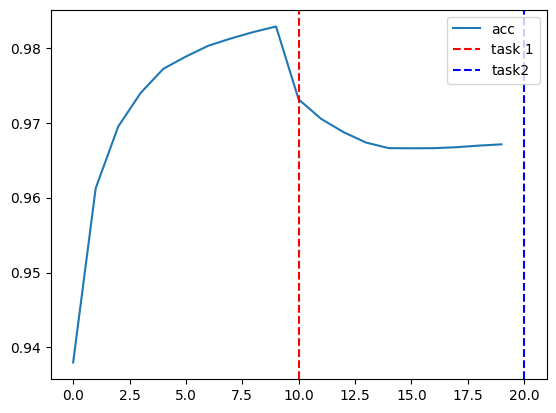

In [61]:
import matplotlib.pyplot as plt

plt.plot(agent_exp.acc_epochs)
plt.axvline(x=10, linestyle = '--', color = 'r')
plt.axvline(x=20, linestyle = '--', color = 'b')
plt.legend(['acc', 'task 1', 'task2'])
plt.show()


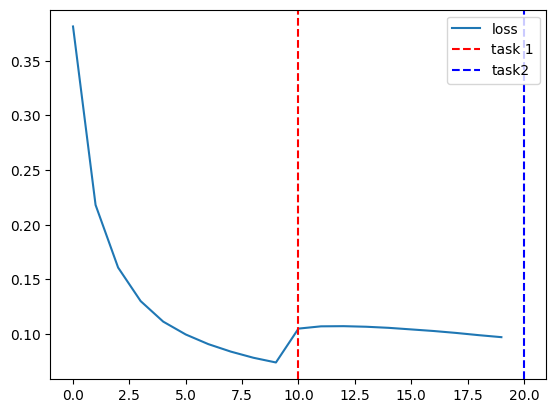

In [62]:

plt.plot(agent_exp.loss_epochs)
plt.axvline(x=10, linestyle = '--', color = 'r')
plt.axvline(x=20, linestyle = '--', color = 'b')
plt.legend(['loss', 'task 1', 'task2'])
plt.show()


In [64]:
accuracy_array = np.array(accuracy_list)

In [66]:
accuracy_array

array([[[0.97751124, 0.        ],
        [0.        , 1.        ]]])

In [65]:
if params.online:
        avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt = compute_performance(accuracy_array)
        print('----------- Total {} run: {}s -----------'.format(params.num_runs, 0))
        print('----------- Avg_End_Acc {} Avg_End_Fgt {} Avg_Acc {} Avg_Bwtp {} Avg_Fwt {}-----------'
              .format(avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt))
else:
        print('----------- Total {} run: {}s -----------'.format(params.num_runs, 0))
        print("avg_end_acc {}".format(np.mean(accuracy_list)))

----------- Total 1 run: 0s -----------
----------- Avg_End_Acc (0.5, nan) Avg_End_Fgt (0.48875562218890556, nan) Avg_Acc (0.7387556221889056, nan) Avg_Bwtp (0.0, nan) Avg_Fwt (0.0, nan)-----------


e:\New folder\conda_\envs\RL\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
e:\New folder\conda_\envs\RL\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
input_size_match['breathing'] = [20,3]
transforms_match['breathing'] = transforms.Compose([
            transforms.ToTensor()])

In [ ]:
params.mem_size

200

In [ ]:
x = torch.FloatTensor(100,*[20, 3])
a = torch.FloatTensor(100,*[20, 3]).fill_(0)
x.size()

torch.Size([100, 20, 3])

In [ ]:
a.size()

torch.Size([100, 20, 3])

In [ ]:
accuracy_list = []
for run in range(params.num_runs):
    tmp_acc = []
    run_start = time.time()
    data_continuum.new_run()
    model = LSTMModel(input_dim=3, hidden_dim=128, layer_dim=1, output_dim=4)
    model = maybe_cuda(model, params.cuda)
    opt = setup_opt(params.optimizer, model, params.learning_rate, params.weight_decay)
    agent = agents[params.agent](model, opt, params)

    # prepare val data loader
    test_loaders = setup_test_loader(data_continuum.test_data(), params)
    if params.online:
        for i, (x_train, y_train, labels) in enumerate(data_continuum):
            print("-----------run {} training batch {}-------------".format(run, i))
            print('size: {}, {}'.format(x_train.shape, y_train.shape))
            agent.train_learner(x_train, y_train)
            acc_array = agent.evaluate(test_loaders)
            tmp_acc.append(acc_array)
        run_end = time.time()
        print(
            "-----------run {}-----------avg_end_acc {}-----------train time {}".format(run, np.mean(tmp_acc[-1]),
                                                                            run_end - run_start))
        accuracy_list.append(np.array(tmp_acc))

Task: 0, Labels:[2, 3]
Task: 1, Labels:[1, 0]
buffer has 200 slots
-----------run 0 training batch 0-------------
size: (2000, 20, 3), (2000,)
torch.Size([10, 1, 20, 3])


RuntimeError: output with shape [10, 20, 3] doesn't match the broadcast shape [10, 10, 20, 3]

### Test Model

#### For CIFAR10


In [ ]:
params.data = 'cifar10'
params.num_tasks = 10


In [ ]:
start = time.time()
print('Setting up data stream')
data_continuum = continuum("cifar10", cl_type, params)
data_end = time.time()
print('data setup time: {}'.format(data_end - start))

Setting up data stream
Files already downloaded and verified
Files already downloaded and verified
data setup time: 1.911750316619873


In [ ]:
params.num_runs = 1

In [ ]:
accuracy_list = []
for run in range(params.num_runs):
    tmp_acc = []
    run_start = time.time()
    data_continuum.new_run()
    model = setup_architecture(params=params)
    model = maybe_cuda(model, params.cuda)
    opt = setup_opt(params.optimizer, model, params.learning_rate, params.weight_decay)
    agent = agents[params.agent](model, opt, params)

    # prepare val data loader
    test_loaders = setup_test_loader(data_continuum.test_data(), params)
    if params.online:
        for i, (x_train, y_train, labels) in enumerate(data_continuum):
            print("-----------run {} training batch {}-------------".format(run, i))
            print('size: {}, {}'.format(x_train.shape, y_train.shape))
            agent.train_learner(x_train, y_train)
            acc_array = agent.evaluate(test_loaders)
            tmp_acc.append(acc_array)
        run_end = time.time()
        print(
            "-----------run {}-----------avg_end_acc {}-----------train time {}".format(run, np.mean(tmp_acc[-1]),
                                                                            run_end - run_start))
        accuracy_list.append(np.array(tmp_acc))




Task: 0, Labels:[1]
Task: 1, Labels:[0]
Task: 2, Labels:[6]
Task: 3, Labels:[2]
Task: 4, Labels:[4]
Task: 5, Labels:[5]
Task: 6, Labels:[3]
Task: 7, Labels:[8]
Task: 8, Labels:[7]
Task: 9, Labels:[9]
buffer has 5000 slots
-----------run 0 training batch 0-------------
size: (5000, 32, 32, 3), (5000,)
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32]

In [ ]:
if params.online:
        avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt = compute_performance(accuracy_array)
        print('----------- Total {} run: {}s -----------'.format(params.num_runs, 0))
        print('----------- Avg_End_Acc {} Avg_End_Fgt {} Avg_Acc {} Avg_Bwtp {} Avg_Fwt {}-----------'
              .format(avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt))
else:
        print('----------- Total {} run: {}s -----------'.format(params.num_runs, 0))
        print("avg_end_acc {}".format(np.mean(accuracy_list)))